# Introduction

Overview

Moving in complex environments is an essential capability of robots. So, to have a better
understanding of the environment and properly navigate a task, they need input about their
environment.
In this competition,we have to build an idea/model which helps robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).
IMU sensor data were collected while driving a small mobile robot over different floor surfaces. The
task is to predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using
sensor data such as acceleration and velocity.

# Data

* X_[train/test].csv - the input data, covering 10 sensor channels and 128 measurements per time series plus
* three ID columns:
* -row_id: The ID for this row.
* -series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.
* -measurement_number: Measurement number within the series.
* The orientation channels encode the current angles how the robot is oriented as a quaternion (see
* Wikipedia). Angular velocity describes the angle and speed of motion, and linear acceleration
* components describe how the speed is changing at different times. The 10 sensor channels are:
* orientation_X
* orientation_Y
* orientation_Z
* orientation_W
* angular_velocity_X
* angular_velocity_Y
* angular_velocity_Z
* linear_acceleration_X
* linear_acceleration_Y
* linear_acceleration_Z
*  y_train.csv - the surfaces for training set.
* -series_id: ID number for the measurement series.
* -group_id: ID number for all of the measurements taken in a recording session. Provided for the training set
* only, to enable more cross validation strategies.
* -surface: the target for this competition.
* sample_submission.csv - a sample submission file in the correct format.

# Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
from numba import jit
import itertools
from seaborn import countplot,lineplot, barplot
from numba import jit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.style as style 
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

!ls ../input/
!ls ../input/robot-best-submission
print ("Ready !")

career-con-2019  robot-best-submission
__results___files    submission.csv	train_denoised.csv
best_submission.csv  test_denoised.csv
Ready !


# Loading Dataset

In [2]:
data = pd.read_csv('../input/career-con-2019/X_train.csv')
tr = pd.read_csv('../input/career-con-2019/X_train.csv')
sub = pd.read_csv('../input/career-con-2019/sample_submission.csv')
test = pd.read_csv('../input/career-con-2019/X_test.csv')
target = pd.read_csv('../input/career-con-2019/y_train.csv')
print ("Data is ready !!")

Data is ready !!


# EDA

In [3]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.18787,0.29492,2.8027,-9.6816
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.18206,0.14944,2.5408,-9.8521
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.18441,-0.49741,2.5853,-9.3835
3,0_3,0,3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.18783,-0.32376,2.9966,-8.7415
4,0_4,0,4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.20170,-0.70103,2.6498,-8.8432


In [5]:
target.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [6]:
len(data.measurement_number.value_counts())

128

128 measurements make up each series.
One series equals 128 measurements.
For instance, the series with series id=0 contains 128 measurements and the surface is = fin concrete.

# Description of Data

In [7]:
data.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792262,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [8]:
test.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098434,-0.037396,-0.029865,-0.089843,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


In [9]:
target.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


# Missing Data Check

In [10]:
totalt = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
print ("Missing Data at Training")
missing_data.tail()

Missing Data at Training


,Total,Percent
angular_velocity_Y,0,0.0
angular_velocity_Z,0,0.0
linear_acceleration_X,0,0.0
linear_acceleration_Y,0,0.0
linear_acceleration_Z,0,0.0


In [11]:
totalt = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
print ("Missing Data at Test")
missing_data.tail()

Missing Data at Test


,Total,Percent
angular_velocity_Y,0,0.0
angular_velocity_Z,0,0.0
linear_acceleration_X,0,0.0
linear_acceleration_Y,0,0.0
linear_acceleration_Z,0,0.0


In [12]:
print ("Test has ", (test.shape[0]-data.shape[0])/128, "series more than Train  = 768 registers")
dif = test.shape[0]-data.shape[0]
print ("Let's analyze these extra 6 series")
test.tail(768).describe()

Test has  6.0 series more than Train  = 768 registers
Let's analyze these extra 6 series


,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3812.500000,63.500000,0.337003,-0.131644,-0.017085,0.050452,-0.000984,0.011186,-0.030018,0.184216,2.915913,-9.364381
std,1.708938,36.973369,0.508982,0.767389,0.115323,0.078381,0.094922,0.050507,0.099772,1.281583,1.772065,2.214824
min,3810.000000,0.000000,-0.451190,-0.901650,-0.138930,-0.065797,-0.400180,-0.170710,-0.272710,-7.314100,-3.502700,-19.655000
25%,3811.000000,31.750000,-0.204643,-0.882522,-0.131210,-0.040565,-0.037407,-0.011643,-0.083618,-0.314090,1.666375,-9.796600
50%,3812.500000,63.500000,0.439235,-0.421170,-0.056428,0.067505,0.002001,0.006310,-0.005417,0.208475,2.939450,-9.376150
75%,3814.000000,95.250000,0.894423,0.867717,0.133082,0.135965,0.038191,0.047069,0.035923,0.633742,3.721350,-9.005425
max,3815.000000,127.000000,0.903020,0.968250,0.146690,0.137700,0.456310,0.177270,0.188970,9.547000,10.233000,3.052800


When comparing the maximum and minimum values from the full test with those from six other test series, the characteristics orientation, angular velocity, and linear acceleration show significant variations (see linear acceleration Z).
This is not a major deal because we are comparing the 3810 series to the 6 series, obviously.

# Important Features : Group_Id

In [13]:
target.groupby('group_id').surface.nunique().max()

1

In [14]:
target['group_id'].nunique()

73

73 groups Each group_id is a robust recording session and has only a single surface type

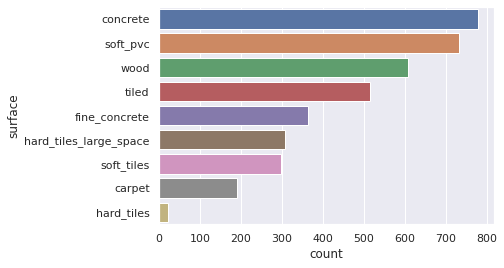

In [15]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

# Target Features: 
# 1. Group_Id
# 2. Surface

distribution of target features

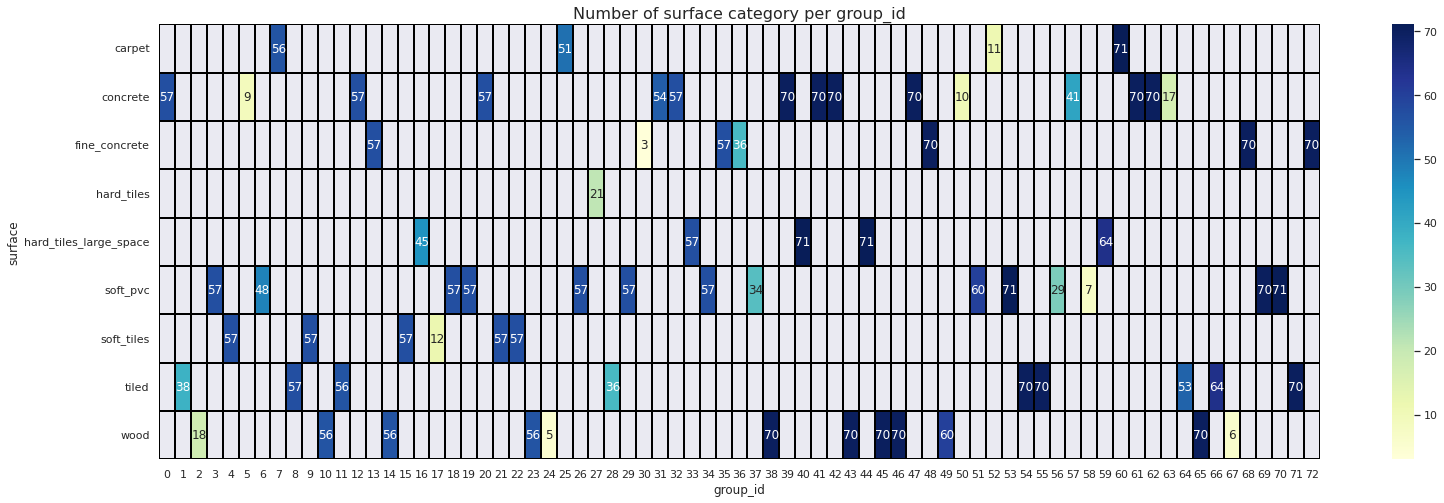

In [16]:
fig, ax = plt.subplots(1,1,figsize=(26,8))
tmp = pd.DataFrame(target.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

# classification of surfaces on which the robot is standing currently
9 surfaces hence 9 classes

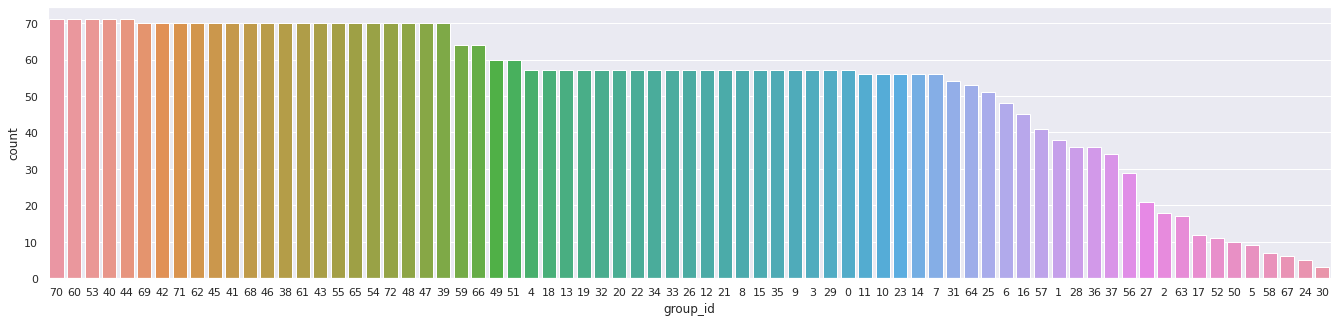

In [17]:
plt.figure(figsize=(23,5)) 
sns.set(style="darkgrid")
countplot(x="group_id", data=target, order = target['group_id'].value_counts().index)
plt.show()

measurement of series 1

In [18]:
serie1 = tr.head(128)
serie1.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [19]:
serie1.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.0,63.500000,-0.758666,-0.634008,-0.105474,-0.106470,-0.002481,-0.003306,0.007532,0.263418,2.984195,-9.320391
std,0.0,37.094474,0.000363,0.000471,0.000432,0.000389,0.052800,0.031544,0.017127,0.911175,1.387790,1.095040
min,0.0,0.000000,-0.759530,-0.634560,-0.106140,-0.107050,-0.160410,-0.079404,-0.030181,-1.864400,0.075417,-12.512000
25%,0.0,31.750000,-0.758927,-0.634383,-0.105873,-0.106775,-0.029069,-0.027110,-0.005289,-0.362872,1.791050,-9.875850
50%,0.0,63.500000,-0.758530,-0.634270,-0.105500,-0.106555,-0.005082,-0.004037,0.006842,0.231665,3.407550,-9.429950
75%,0.0,95.250000,-0.758367,-0.633530,-0.105078,-0.106130,0.035803,0.020031,0.020088,0.905635,4.119200,-8.633425
max,0.0,127.000000,-0.758220,-0.633060,-0.104610,-0.105590,0.107650,0.072698,0.051720,2.853800,5.386400,-6.268100


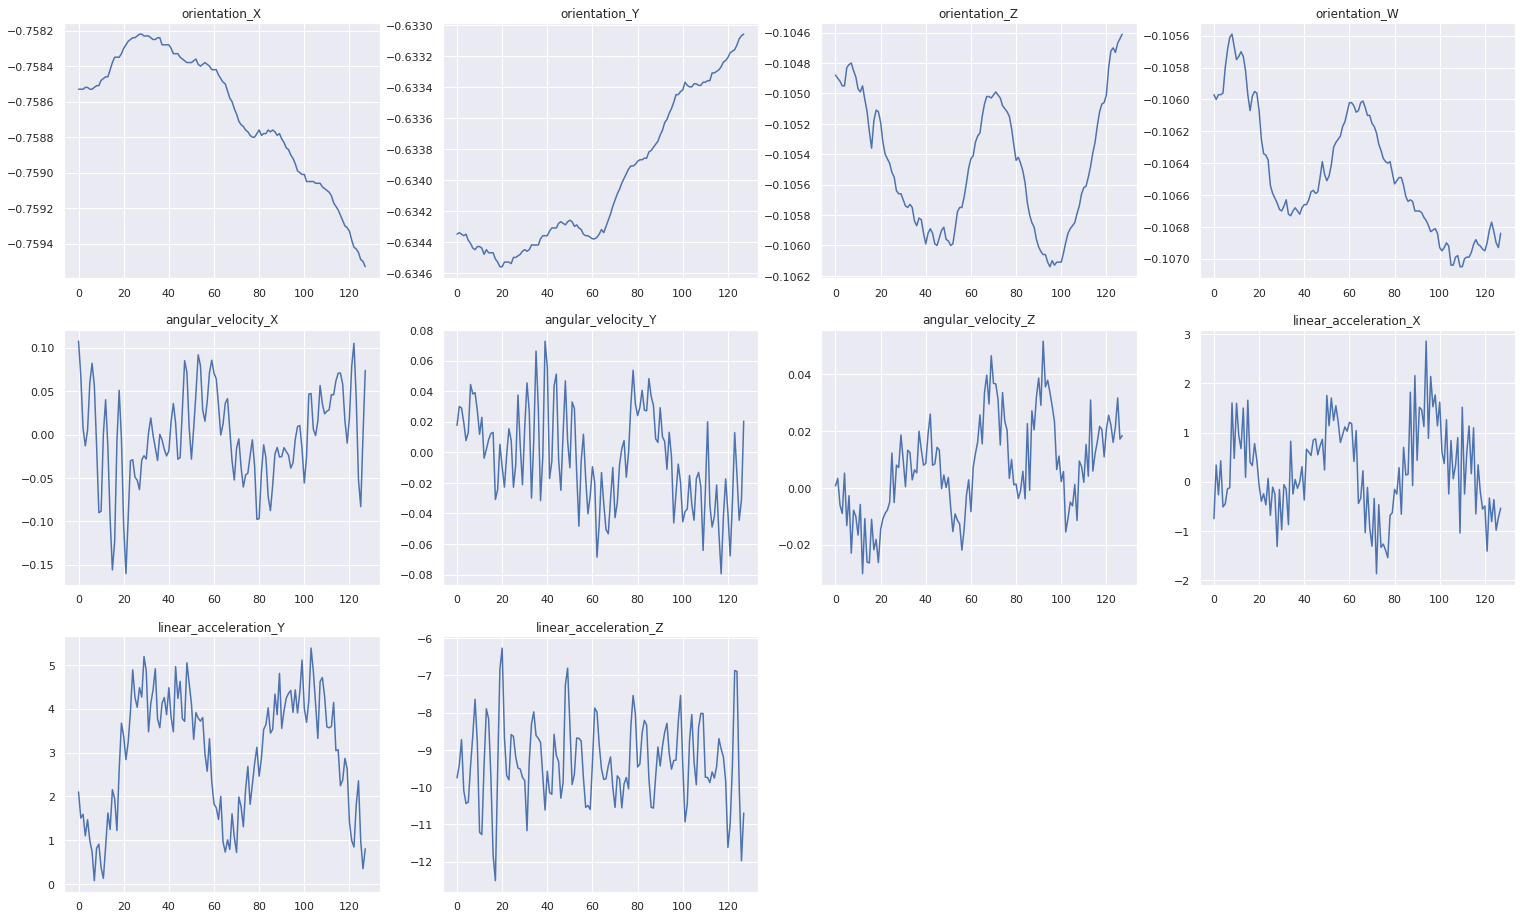

In [20]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(serie1.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(serie1[col])
    plt.title(col)

In [21]:
target.head(1)

,series_id,group_id,surface
0,0,13,fine_concrete


In [22]:
del serie1
gc.collect()

41294

# Function to plot any series

In [23]:
series_dict = {}
for series in (data['series_id'].unique()):
    series_dict[series] = data[data['series_id'] == series] 

In [24]:
def plotSeries(series_id):
    style.use('ggplot')
    plt.figure(figsize=(28, 16))
    print(target[target['series_id'] == series_id]['surface'].values[0].title())
    for i, col in enumerate(series_dict[series_id].columns[3:]):
        if col.startswith("o"):
            color = 'red'
        elif col.startswith("a"):
            color = 'green'
        else:
            color = 'blue'
        if i >= 7:
            i+=1
        plt.subplot(3, 4, i + 1)
        plt.plot(series_dict[series_id][col], color=color, linewidth=3)
        plt.title(col)

Carpet


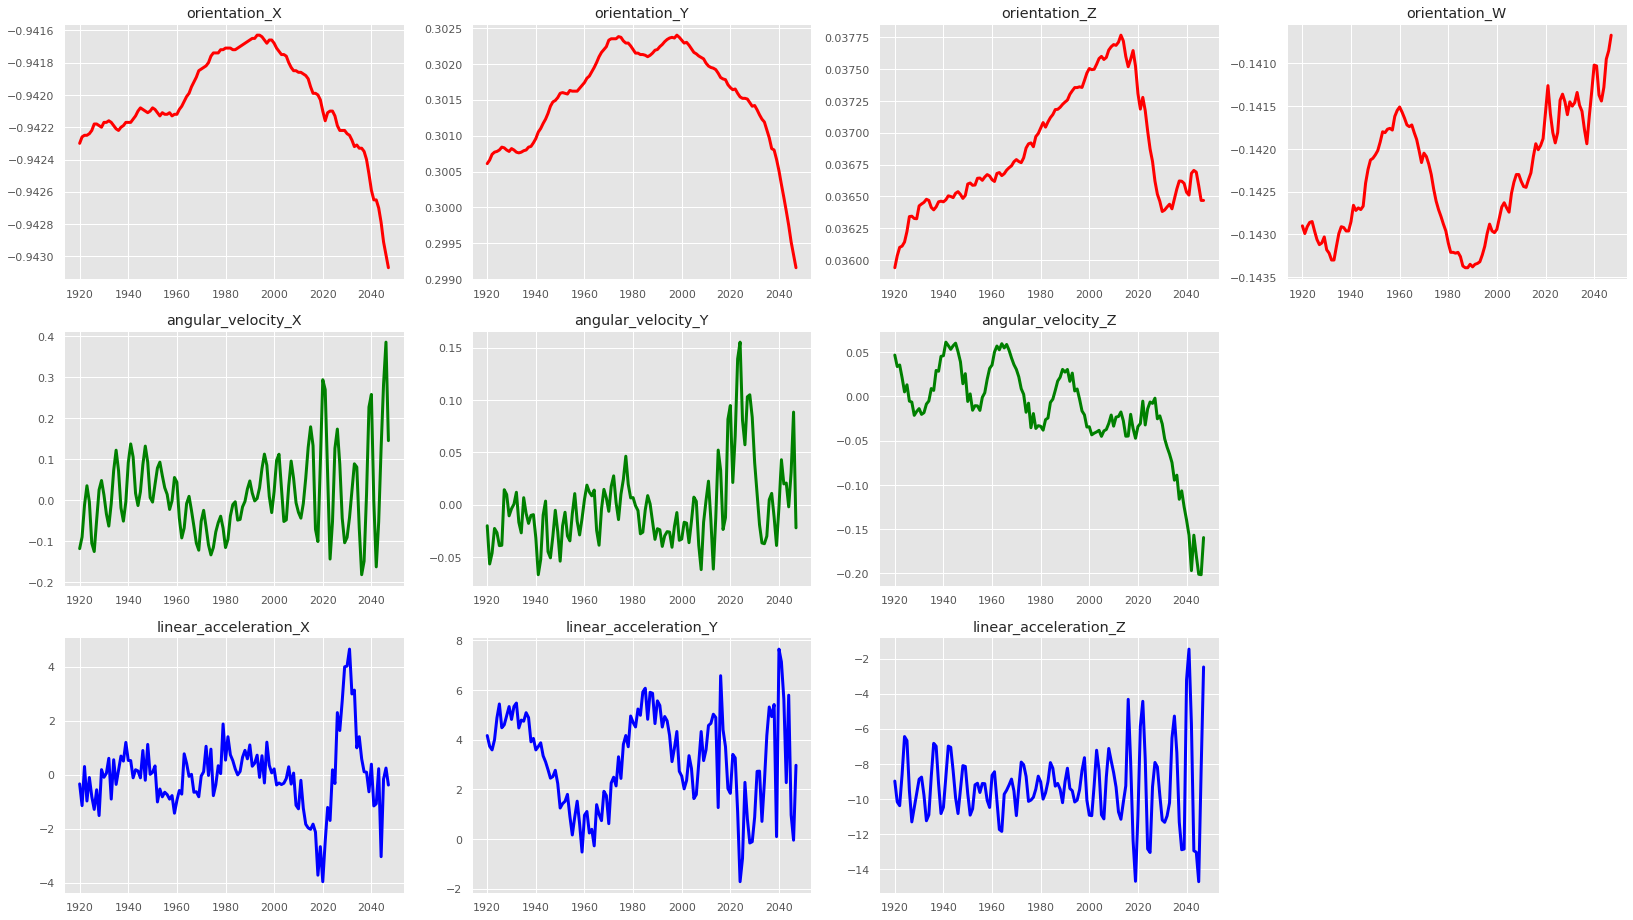

In [25]:
id_series = 15
plotSeries(id_series)

In [26]:
del series_dict
gc.collect()

29320

# Correlations

<AxesSubplot:>

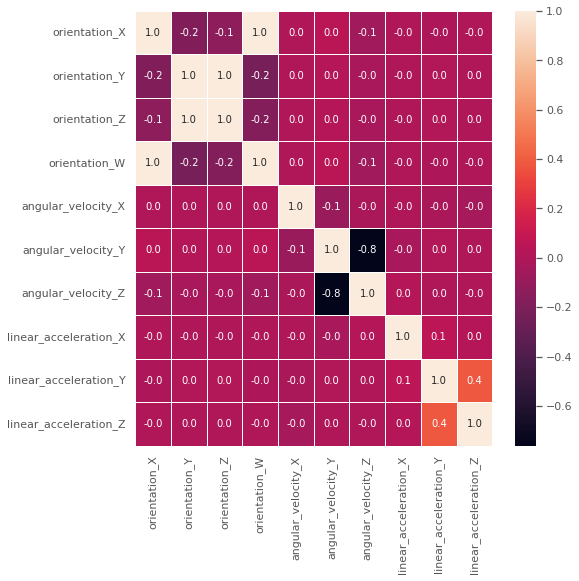

In [27]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(tr.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

<AxesSubplot:>

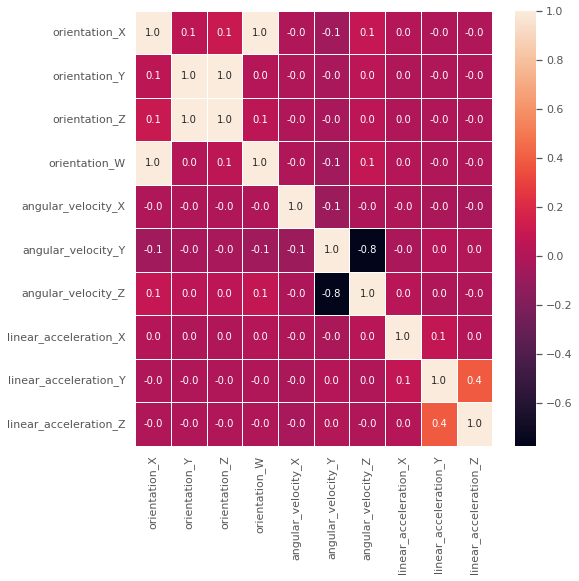

In [28]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(test.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# inferences from heat maps
# there is a strong correlation between:
* angular_velocity_Z and angular_velocity_Y
* orientation_X and orientation_Y
* orientation_Y and orientation_Z

# Moreover, test has different correlations than training, for example:
* angular_velocity_Z and orientation_X: -0.1(training) and 0.1(test).

In [29]:
!ls ../input

career-con-2019  robot-best-submission


# Analysis of Fourier
My expectation was that varied surface types would result in (noticeable) variations in the sensor measurements' frequency spectrum.
Frequency filters may be learned by machine learning techniques on their own, but why not give the machine a little head start? I then calculated the cyclic FFT for the angular velocity and linear acceleration sensors, plotted the mean and standard deviation of the absolute values of the frequency components for each training surface category (leaving out the frequency 0), and then calculated the frequency 0 for the sensors (i.e. constants like sensor bias, earth gravity, ...).
As a result, surface type distinctive peaks are not pleasant and strong. However, that does not imply that there is nothing that more advanced statistical techniques cannot identify.

In [30]:
train_x = pd.read_csv('../input/career-con-2019/X_train.csv')
train_y = pd.read_csv('../input/career-con-2019/y_train.csv')

In [31]:
import math

def prepare_data(t):
    def f(d):
        d=d.sort_values(by=['measurement_number'])
        return pd.DataFrame({
         'lx':[ d['linear_acceleration_X'].values ],
         'ly':[ d['linear_acceleration_Y'].values ],
         'lz':[ d['linear_acceleration_Z'].values ],
         'ax':[ d['angular_velocity_X'].values ],
         'ay':[ d['angular_velocity_Y'].values ],
         'az':[ d['angular_velocity_Z'].values ],
        })

    t= t.groupby('series_id').apply(f)

    def mfft(x):
        return [ x/math.sqrt(128.0) for x in np.absolute(np.fft.fft(x)) ][1:65]

    t['lx_f']=[ mfft(x) for x in t['lx'].values ]
    t['ly_f']=[ mfft(x) for x in t['ly'].values ]
    t['lz_f']=[ mfft(x) for x in t['lz'].values ]
    t['ax_f']=[ mfft(x) for x in t['ax'].values ]
    t['ay_f']=[ mfft(x) for x in t['ay'].values ]
    t['az_f']=[ mfft(x) for x in t['az'].values ]
    return t

In [32]:
t=prepare_data(train_x)
t=pd.merge(t,train_y[['series_id','surface','group_id']],on='series_id')
t=t.rename(columns={"surface": "y"})

In [33]:
def aggf(d, feature):
    va= np.array(d[feature].tolist())
    mean= sum(va)/va.shape[0]
    var= sum([ (va[i,:]-mean)**2 for i in range(va.shape[0]) ])/va.shape[0]
    dev= [ math.sqrt(x) for x in var ]
    return pd.DataFrame({
        'mean': [ mean ],
        'dev' : [ dev ],
    })

display={
'hard_tiles_large_space':'r-.',
'concrete':'g-.',
'tiled':'b-.',

'fine_concrete':'r-',
'wood':'g-',
'carpet':'b-',
'soft_pvc':'y-',

'hard_tiles':'r--',
'soft_tiles':'g--',
}

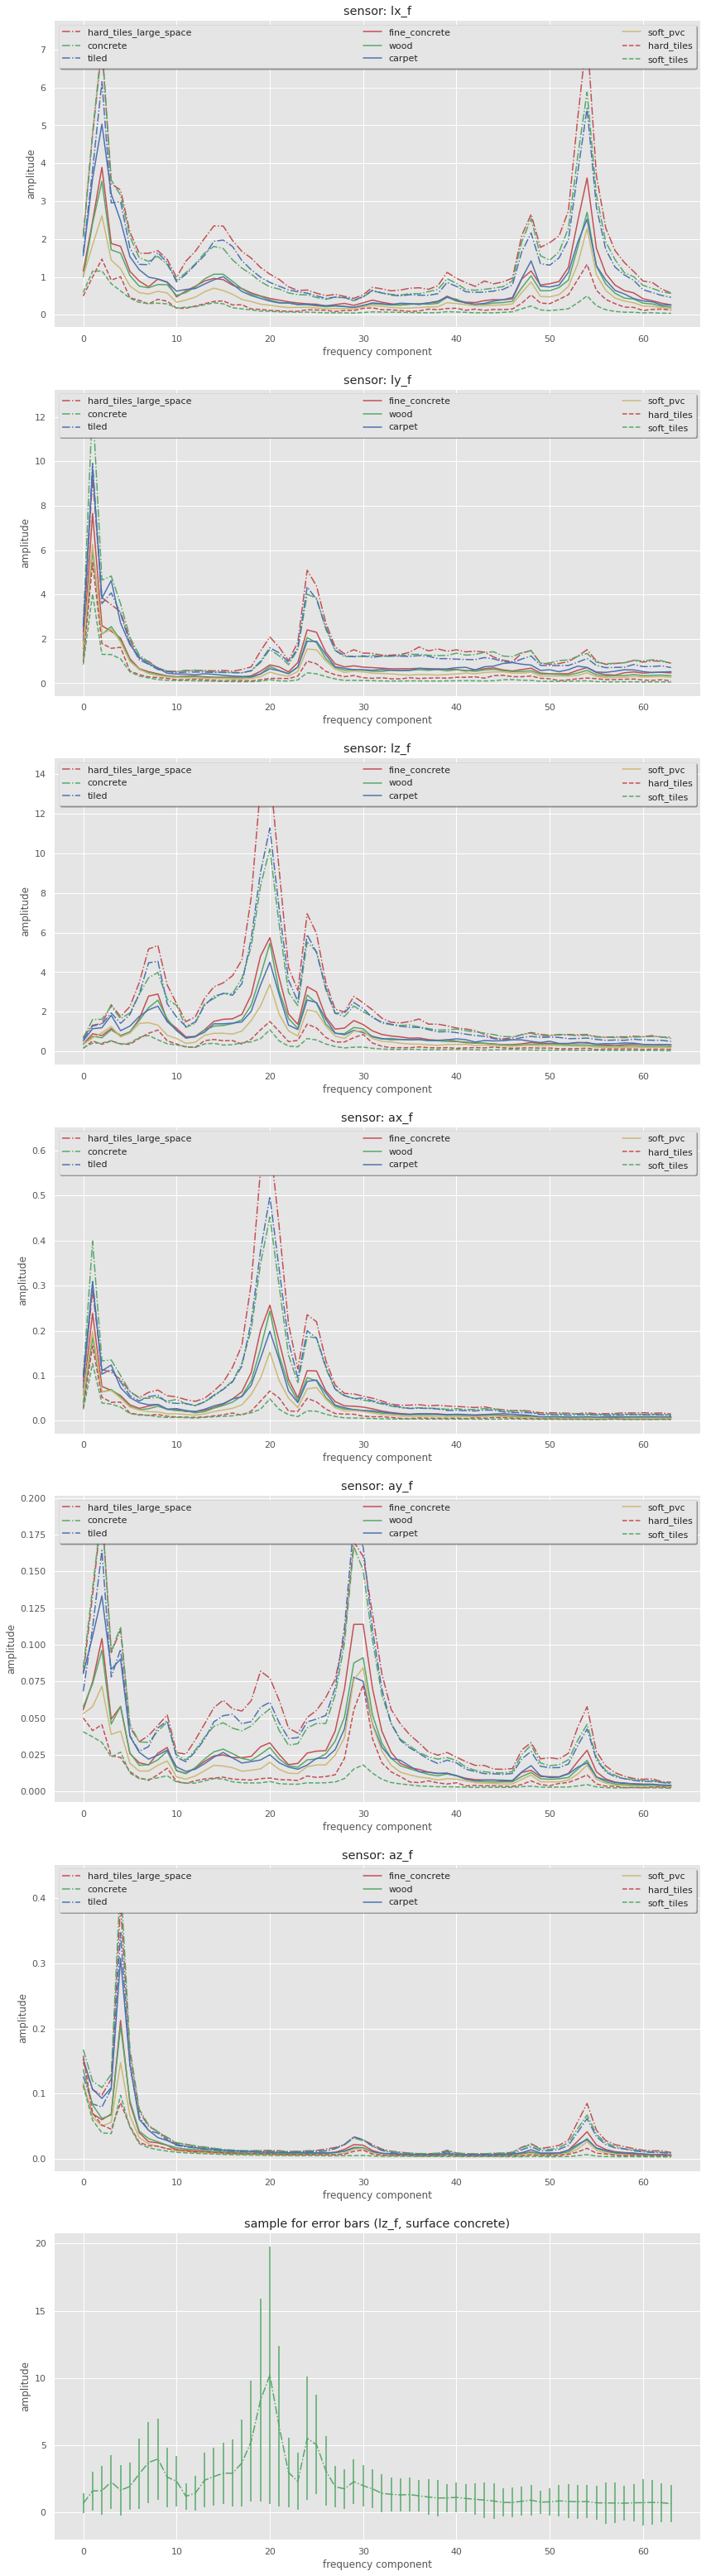

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8*7))
#plt.margins(x=0.0, y=0.0)
#plt.tight_layout()
# plt.figure()

features=['lx_f','ly_f','lz_f','ax_f','ay_f','az_f']
count=0

for feature in features:
    stat= t.groupby('y').apply(aggf,feature)
    stat.index= stat.index.droplevel(-1)
    b=[*range(len(stat.at['carpet','mean']))]

    count+=1
    plt.subplot(len(features)+1,1,count)
    for i,(k,v) in enumerate(display.items()):
        plt.plot(b, stat.at[k,'mean'], v, label=k)
        # plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
   
    leg = plt.legend(loc='best', ncol=3, mode="expand", shadow=True, fancybox=True)
    plt.title("sensor: " + feature)
    plt.xlabel("frequency component")
    plt.ylabel("amplitude")

count+=1
plt.subplot(len(features)+1,1,count)
k='concrete'
v=display[k]
feature='lz_f'
stat= t.groupby('y').apply(aggf,feature)
stat.index= stat.index.droplevel(-1)
b=[*range(len(stat.at['carpet','mean']))]

plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
plt.title("sample for error bars (lz_f, surface concrete)")
plt.xlabel("frequency component")
plt.ylabel("amplitude")

plt.show()

In [35]:
del train_x, train_y
gc.collect()

51

# Engineering the selected Features

In [36]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

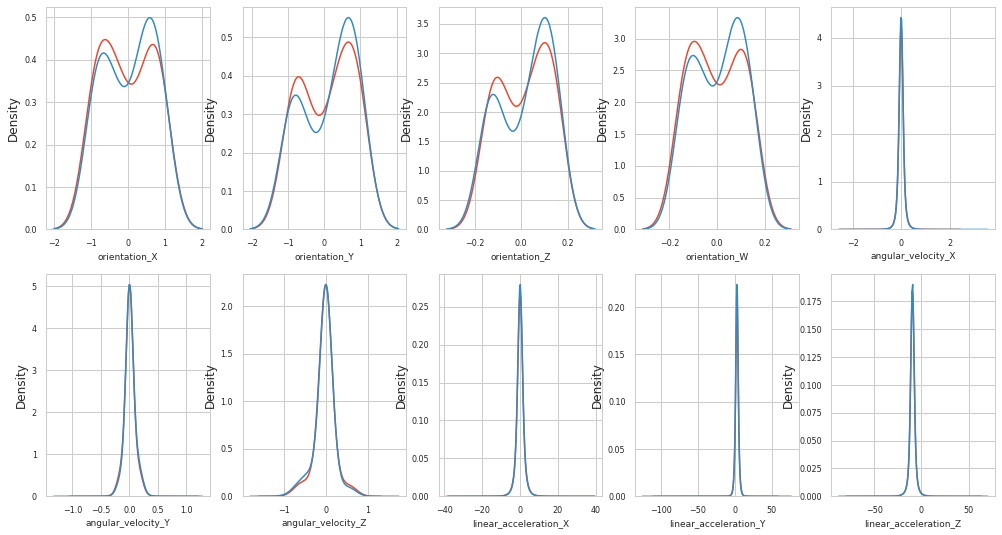

In [37]:
features = data.columns.values[3:]
plot_feature_distribution(data, test, 'train', 'test', features)

On test and training, our core features have the same distribution (Normal). Between orientation X, orientation Y, and linear acceleration Y, there are some variances.

I'll attempt StandardScaler to correct this, and keep in mind that linear acceleration, angular velocity, and orientation are all measured using various units; scaling may be a good option.

In [38]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

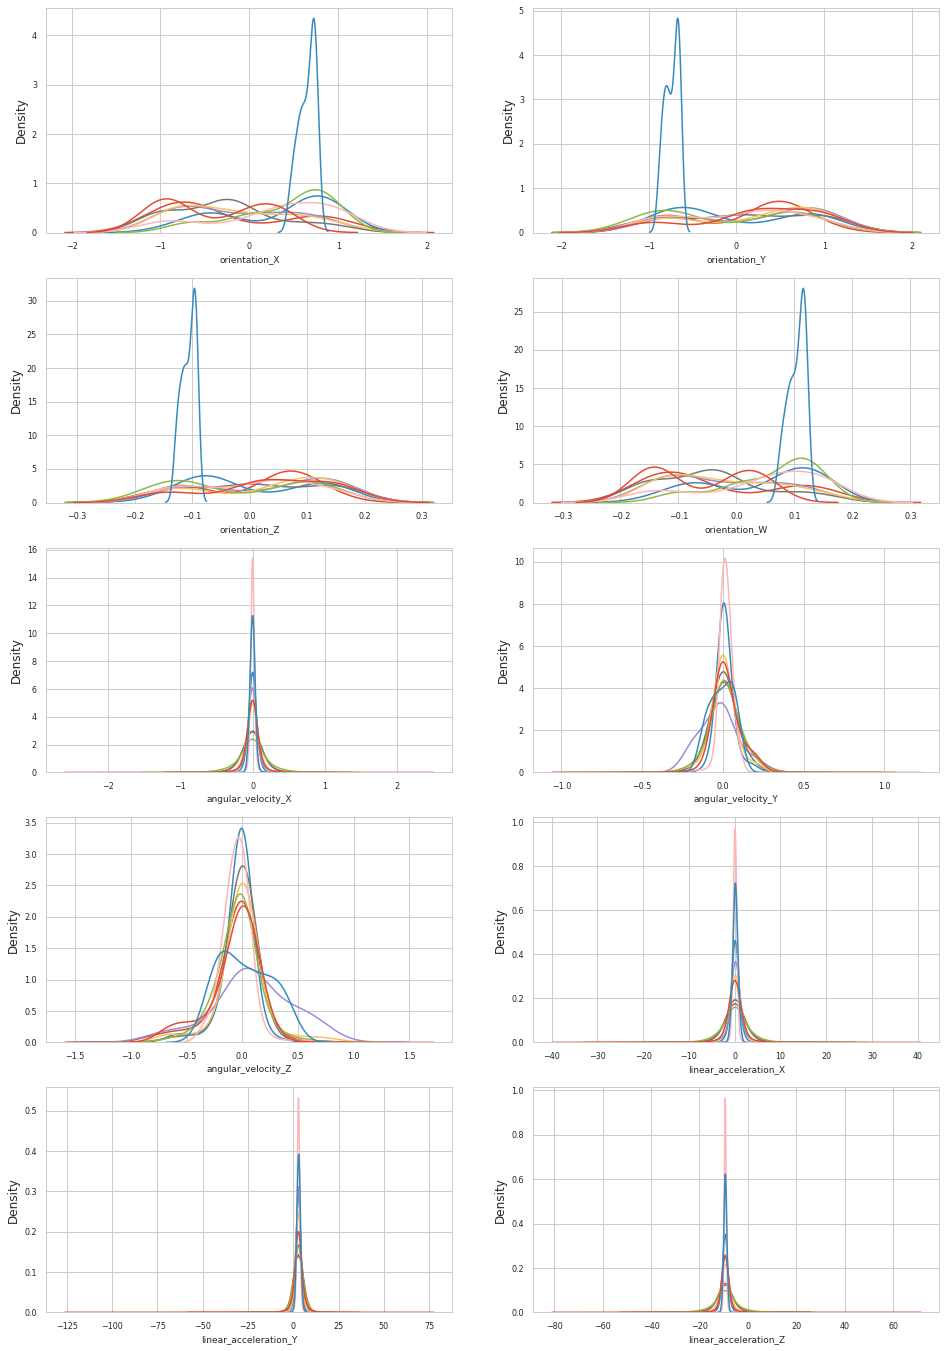

In [39]:
classes = (target['surface'].value_counts()).index
aux = data.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, aux, features)

scaling with more precision

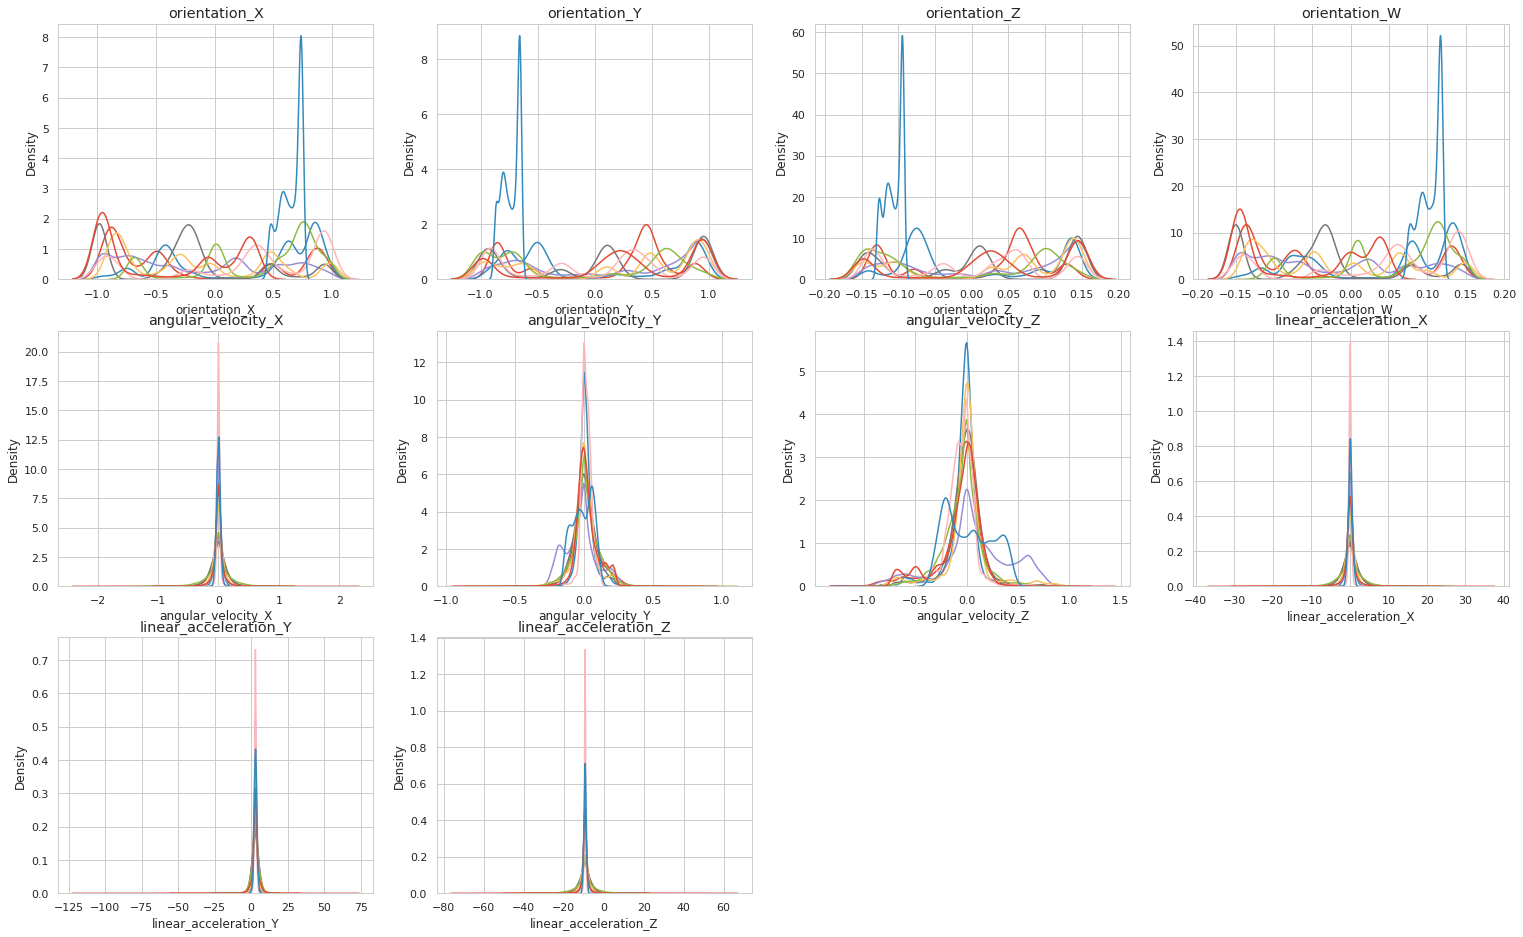

In [40]:
plt.figure(figsize=(26, 16))
for i,col in enumerate(aux.columns[3:13]):
    ax = plt.subplot(3,4,i+1)
    ax = plt.title(col)
    for surface in classes:
        surface_feature = aux[aux['surface'] == surface]
        sns.kdeplot(surface_feature[col], label = surface)

Histogram of features

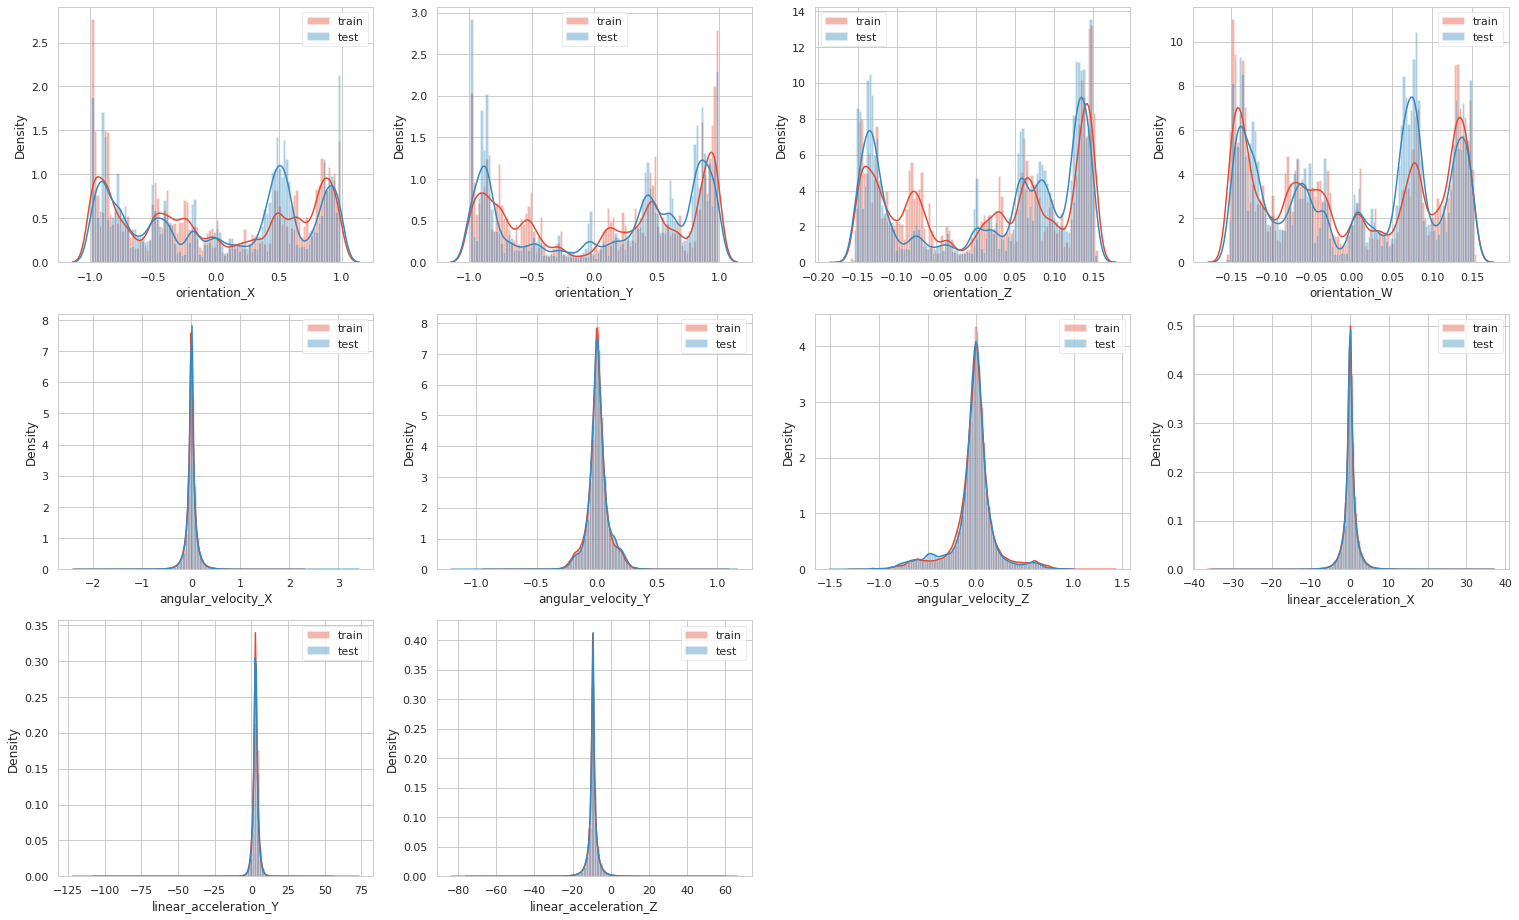

In [41]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(data.columns[3:]):
    ax = plt.subplot(3, 4, i + 1)
    sns.distplot(data[col], bins=100, label='train')
    sns.distplot(test[col], bins=100, label='test')
    ax.legend()   


# Quaternions
Quaternion coordinates for orientation The four coordinates are X, Y, Z, and W, as you can see.
We typically have the X, Y, and Z Euler angles. But as the pitch angle becomes close to +/- 90 degrees, a condition known as "gimbal lock" precludes Euler Angles from measuring orientation. An alternate measurement method without gimbal lock is provided by quaternions. Compared to Euler Angles, quaternions are less understandable, and the math may also be a little more challenging

In [42]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [43]:
def fe_step0 (actual):
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

In [44]:
data = fe_step0(data)
test = fe_step0(test)
print(data.shape)
data.head()

(487680, 19)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596


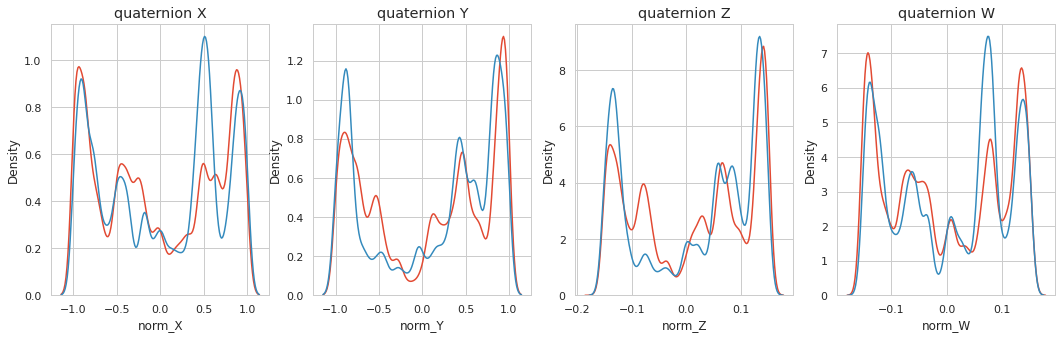

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18, 5))

ax1.set_title('quaternion X')
sns.kdeplot(data['norm_X'], ax=ax1, label="train")
sns.kdeplot(test['norm_X'], ax=ax1, label="test")

ax2.set_title('quaternion Y')
sns.kdeplot(data['norm_Y'], ax=ax2, label="train")
sns.kdeplot(test['norm_Y'], ax=ax2, label="test")

ax3.set_title('quaternion Z')
sns.kdeplot(data['norm_Z'], ax=ax3, label="train")
sns.kdeplot(test['norm_Z'], ax=ax3, label="test")

ax4.set_title('quaternion W')
sns.kdeplot(data['norm_W'], ax=ax4, label="train")
sns.kdeplot(test['norm_W'], ax=ax4, label="test")

plt.show()

# Step 1: quaternions to euler angles

In [46]:
def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [47]:
data = fe_step1(data)
test = fe_step1(test)
print (data.shape)
data.head()

(487680, 22)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


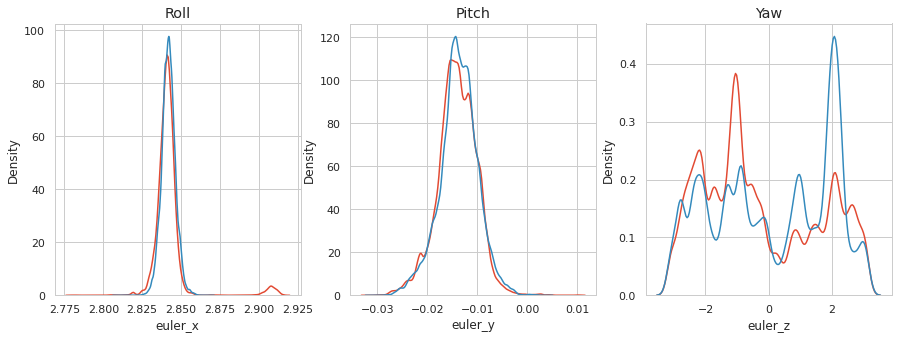

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

ax1.set_title('Roll')
sns.kdeplot(data['euler_x'], ax=ax1, label="train")
sns.kdeplot(test['euler_x'], ax=ax1, label="test")

ax2.set_title('Pitch')
sns.kdeplot(data['euler_y'], ax=ax2, label="train")
sns.kdeplot(test['euler_y'], ax=ax2, label="test")

ax3.set_title('Yaw')
sns.kdeplot(data['euler_z'], ax=ax3, label="train")
sns.kdeplot(test['euler_z'], ax=ax3, label="test")

plt.show()

# Why Orientation_Z (euler angle Z) is so important?
Imagine a robot travelling directly through several surfaces (each with a particular feature), such as concrete and hard tile flooring, like we have one moving about. If the surface is not flat and smooth, our robot may bounce or attempt to balance itself slightly; for this reason, we must deal with quaternions and pay attention to orientation Z.

In [49]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


# Step 2:  Basic features

In [50]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [51]:
%%time
data = feat_eng(data)
test = feat_eng(test)
print ("New features: ",data.shape)

New features:  (3810, 276)
CPU times: user 1min 33s, sys: 276 ms, total: 1min 33s
Wall time: 1min 34s


In [52]:
data.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,...,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_mean_change_of_abs_change,acc_vs_vel_abs_max,acc_vs_vel_abs_min,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,2.380952e-07,0.75953,...,995.561076,56.133014,135.641510,939.428062,17.735749,114.896199,1.309785,995.561076,56.133014,525.847045
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,-4.761905e-07,0.95896,...,611.826712,32.938319,88.488750,578.888393,18.574922,57.943094,0.508448,611.826712,32.938319,322.382516
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.000000e+00,0.51434,...,904.269577,52.834789,132.789650,851.434788,17.115041,83.878164,-0.078679,904.269577,52.834789,478.552183
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.000026,-6.349206e-07,0.93968,...,805.924410,11.305069,112.264757,794.619341,71.288762,76.773215,0.928182,805.924410,11.305069,408.614740
4,-0.891301,-0.890940,-0.88673,-0.89689,0.002955,0.01016,0.988672,0.000080,7.936508e-08,0.89689,...,111.588333,39.895232,16.611029,71.693101,2.797034,5.618844,-0.003968,111.588333,39.895232,75.741783


# Advanced Featured

In [53]:
from scipy.stats import kurtosis
from scipy.stats import skew

def _kurtosis(x):
    return kurtosis(x)

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def skewness(x):
    return skew(x)

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(np.heaviside(-xn*xn_i2,0))

# Advanced Features on the basis of robust statistics

In [54]:
def fe_advanced_stats(data):
    
    df = pd.DataFrame()
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        if 'orientation' in col:
            continue
            
        print ("FE on column ", col, "...")
        
        df[col + '_skew'] = data.groupby(['series_id'])[col].skew()
        df[col + '_mad'] = data.groupby(['series_id'])[col].mad()
        df[col + '_q25'] = data.groupby(['series_id'])[col].quantile(0.25)
        df[col + '_q75'] = data.groupby(['series_id'])[col].quantile(0.75)
        df[col + '_q95'] = data.groupby(['series_id'])[col].quantile(0.95)
        df[col + '_iqr'] = df[col + '_q75'] - df[col + '_q25']
        df[col + '_CPT5'] = data.groupby(['series_id'])[col].apply(CPT5) 
        df[col + '_SSC'] = data.groupby(['series_id'])[col].apply(SSC) 
        df[col + '_skewness'] = data.groupby(['series_id'])[col].apply(skewness)
        df[col + '_wave_lenght'] = data.groupby(['series_id'])[col].apply(wave_length)
        df[col + '_norm_entropy'] = data.groupby(['series_id'])[col].apply(norm_entropy)
        df[col + '_SRAV'] = data.groupby(['series_id'])[col].apply(SRAV)
        df[col + '_kurtosis'] = data.groupby(['series_id'])[col].apply(_kurtosis) 
        df[col + '_zero_crossing'] = data.groupby(['series_id'])[col].apply(zero_crossing) 
        
    return df

In [55]:
basic_fe = ['linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z',
           'angular_velocity_X','angular_velocity_Y','angular_velocity_Z']

In [56]:
def fe_plus (data):
    
    aux = pd.DataFrame()
    
    for serie in data.index:
        #if serie%500 == 0: print ("> Serie = ",serie)
        
        aux = X_train[X_train['series_id']==serie]
        
        for col in basic_fe:
            data.loc[serie,col + '_unq'] = aux[col].round(3).nunique()
            data.loc[serie,col + 'ratio_unq'] = aux[col].round(3).nunique()/18
            try:
                data.loc[serie,col + '_freq'] = aux[col].value_counts().idxmax()
            except:
                data.loc[serie,col + '_freq'] = 0
            
            data.loc[serie,col + '_max_freq'] = aux[aux[col] == aux[col].max()].shape[0]
            data.loc[serie,col + '_min_freq'] = aux[aux[col] == aux[col].min()].shape[0]
            data.loc[serie,col + '_pos_freq'] = aux[aux[col] >= 0].shape[0]
            data.loc[serie,col + '_neg_freq'] = aux[aux[col] < 0].shape[0]
            data.loc[serie,col + '_nzeros'] = (aux[col]==0).sum(axis=0)

# Correlation check - 2

In [57]:
corr_matrix = data.corr().abs()
raw_corr = data.corr()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
top_corr = pd.DataFrame(sol).reset_index()
top_corr.columns = ["var1", "var2", "abs corr"]
# with .abs() we lost the sign, and it's very important.
for x in range(len(top_corr)):
    var1 = top_corr.iloc[x]["var1"]
    var2 = top_corr.iloc[x]["var2"]
    corr = raw_corr[var1][var2]
    top_corr.at[x, "raw corr"] = corr

In [58]:
top_corr.head(15)

,var1,var2,abs corr,raw corr
0,norm_quat_max,mod_quat_max,1.0,1.0
1,norm_quat_max,mod_quat_abs_max,1.0,1.0
2,norm_quat_abs_max,mod_quat_max,1.0,1.0
3,norm_quat_abs_max,mod_quat_abs_max,1.0,1.0
4,norm_quat_median,mod_quat_median,1.0,1.0
5,norm_quat_abs_min,mod_quat_min,1.0,1.0
6,norm_quat_min,mod_quat_abs_min,1.0,1.0
7,norm_quat_abs_min,mod_quat_abs_min,1.0,1.0
8,norm_quat_min,mod_quat_min,1.0,1.0
9,totl_xyz_max,totl_xyz_abs_max,1.0,1.0


In [59]:
data.fillna(0,inplace=True)
test.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

# Label Encoding

In [60]:
target.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [61]:
target['surface'] = le.fit_transform(target['surface'])

In [62]:
target['surface'].value_counts()

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface, dtype: int64

In [63]:
target.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


# Model : Random Forest

use random_state at Random Forest
if you don't use random_state you will get a different solution everytime, sometimes you will be lucky, but other times you will lose your time comparing.
Validation Strategy: Stratified KFold


In [64]:
folds = StratifiedKFold(n_splits=2, shuffle=True, random_state=59)

In [65]:
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0

In [66]:
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = data.columns
    
    if model.score(data.iloc[val_idx],target['surface'][val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    gc.collect()

Fold: 0 score: 0.8766404199475065
Fold: 1 score: 0.883989501312336


In [67]:
print('Avg Accuracy RF', (score / folds.n_splits)*100)

Avg Accuracy RF 88.03149606299212


# Confusion Matrix plot

In [68]:
confusion_matrix(measured,target['surface'])

array([[161,   6,   0,   0,   3,   4,   2,   4,   3],
       [ 11, 689,  10,   0,  18,  15,   6,  25,  19],
       [  0,   6, 293,   0,   4,   6,   1,   0,   8],
       [  0,   0,   0,  12,   0,   0,   0,   0,   0],
       [  1,   8,   7,   0, 271,   4,   0,   5,   0],
       [  5,  24,  11,   1,   2, 678,   2,  12,  30],
       [  0,  11,   5,   2,   2,   2, 278,   4,   6],
       [  1,   5,   5,   0,   0,   3,   1, 451,  20],
       [ 10,  30,  32,   6,   8,  20,   7,  13, 521]])

In [69]:
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

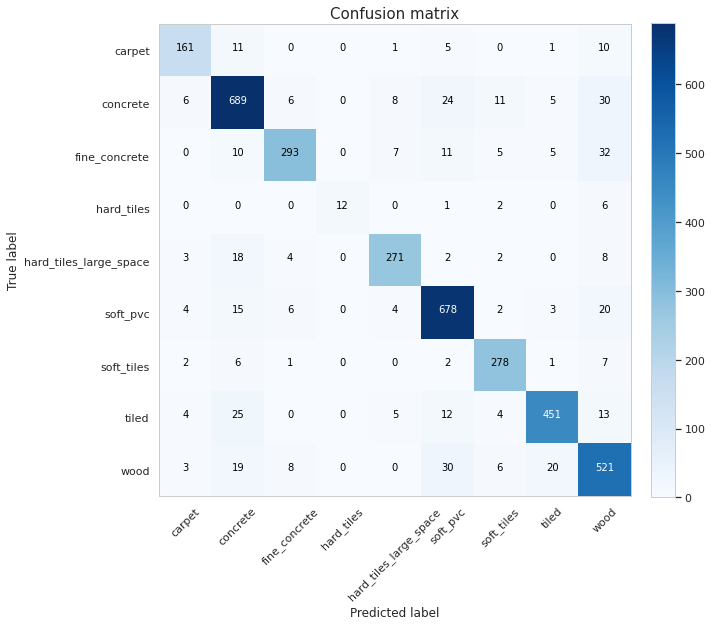

In [70]:
plot_confusion_matrix(target['surface'], measured, le.classes_)


# submission to hack2skill

In [71]:
sub['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sub.to_csv('submission.csv', index=False)
sub.head()

,series_id,surface
0,0,soft_pvc
1,1,wood
2,2,concrete
3,3,wood
4,4,concrete
